In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from dimod import BinaryQuadraticModel
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler
from dwave.system import DWaveSampler, FixedEmbeddingComposite
import dwave_networkx as dnx
import dwave.inspector

from plotters import plotHistogram, plotBoundaryStrength, plotSampleGraph, plotArrangement, annotateSampleGraph, plotCSV
from qubo import createBQM
from sampleRecording import recordSample, findOverlaps, totalEntropy

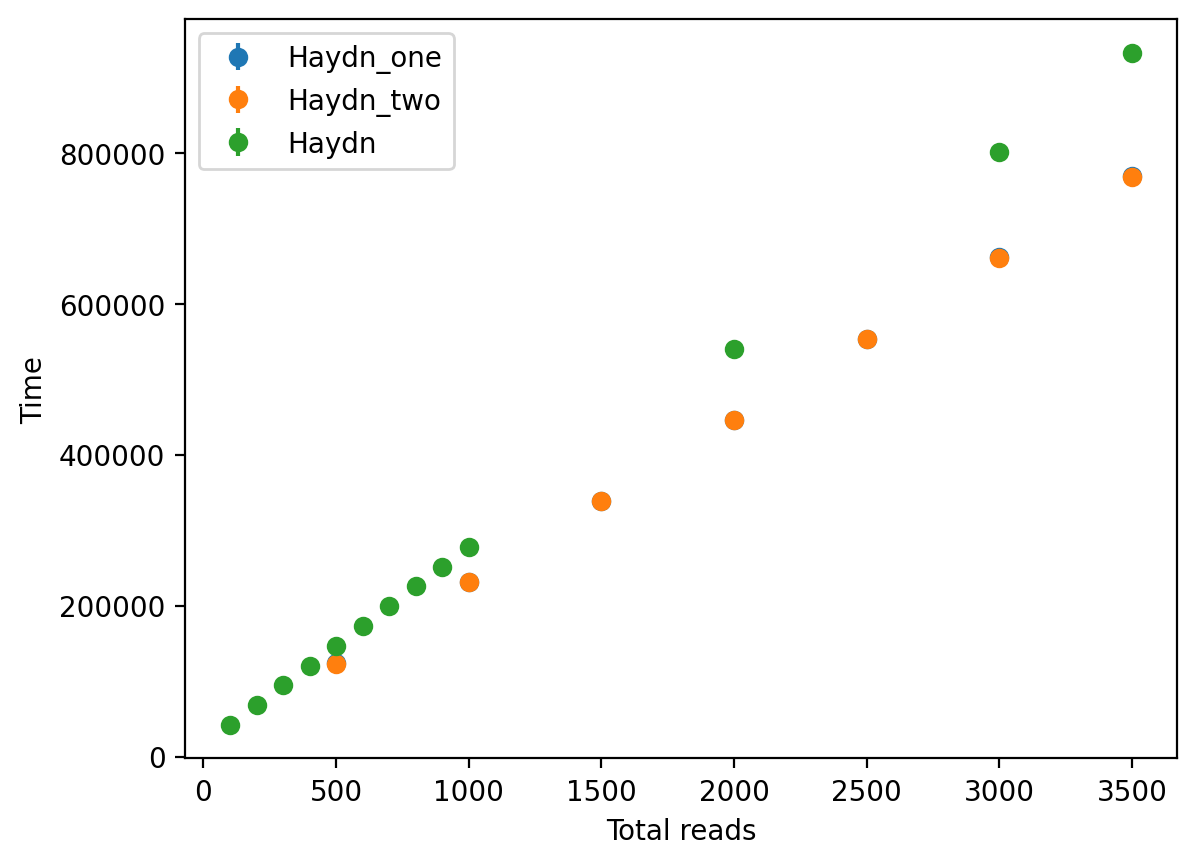

In [24]:
identifiers = ["Haydn_one", "Haydn_two", "Haydn"]
embeddings = []
bqms = []

for i in identifiers:
    path = f"../Pickles/{i}/{i}_"
    bqms.append(BinaryQuadraticModel.from_serializable(json.load(open(path + "bqm.json", "r"))))
    embeddings.append(json.load(open(path + "embedding.json", "r")))

    plotCSV(path+"qa-reads.csv", "Total reads", "Time", label=i)

plt.legend()
plt.show()

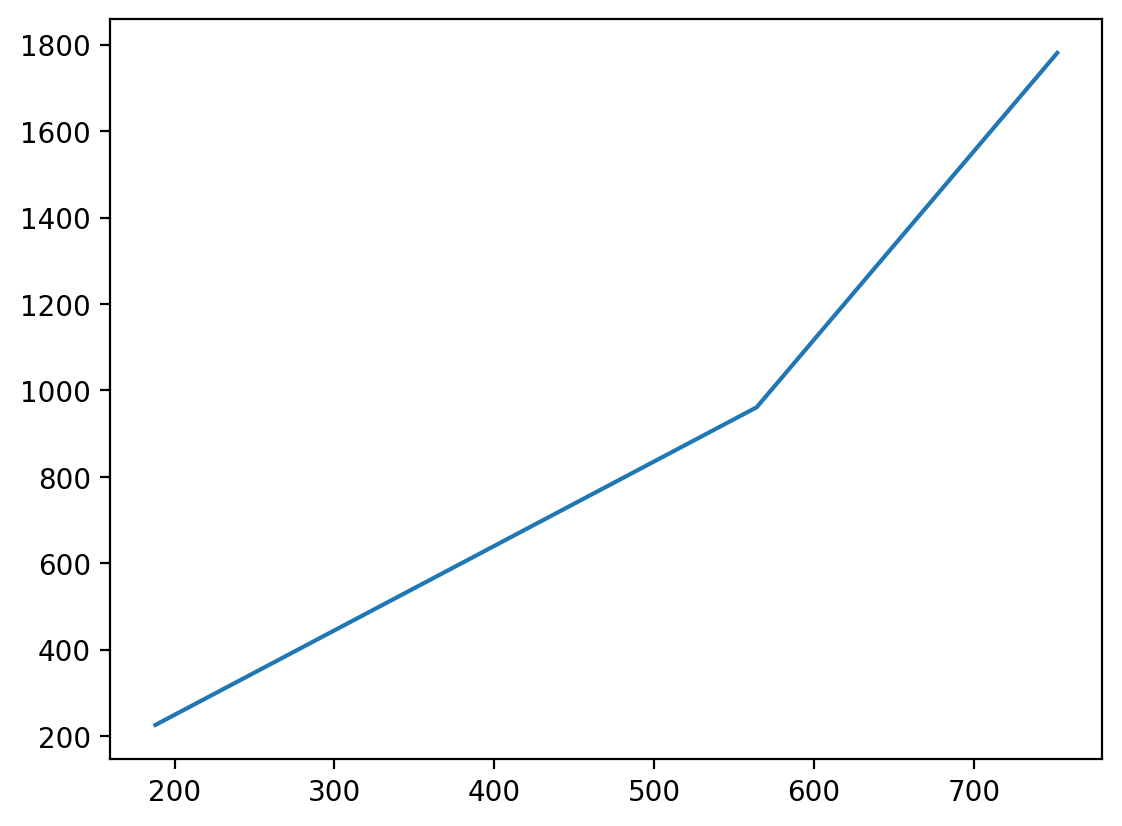

In [19]:
variables = [len(b.linear) for b in bqms]
qubits = [sum(len(i) for i in e.values()) for e in embeddings]

plt.plot(variables, qubits)
# Now we have 752 variables in BQM instead of the WRONG 565 (188 * 3 + 1)

In [37]:
sampleset = sampler.sample(bqm, num_reads=100, label=f"Haydn_{100}")